In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import OLS, add_constant
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [146]:
# Load Room Rates dataset
room_rates = pd.read_csv('/kaggle/input/hotel-hongkong/average_achieved_hotel_room_rate_by_category_en.csv')
room_rates.head()

,Year-Month,Average_achieved_hotel_room_rate_of_High_Tariff_A_Hotel(HKD),Average_achieved_hotel_room_rate_of_High_Tariff_B_Hotel(HKD),Average_achieved_hotel_room_rate_of_Medium_Tariff_Hotel(HKD)
0,201912,1922,752,486
1,202001,1879,700,457
2,202002,1843,619,430
3,202003,1675,602,436
4,202004,1536,586,425


In [147]:
# Load Occupancy dataset
occupancy = pd.read_csv('/kaggle/input/hotel-hongkong/hotel_room_occupancy_rate_monthly_en.csv')
occupancy.head()

,Year-Month,Hotel_room_occupancy_rate(%)
0,201912,61
1,202001,59
2,202002,29
3,202003,32
4,202004,34


In [148]:
# Load Rooms Available dataset
rooms_available = pd.read_csv('/kaggle/input/hotel-hongkong/Number_of_hotel_rooms_in_Hong_Kong_by_hotel_category_en.csv')
rooms_available.head()

,Year-Month,Number of high tariff A hotel rooms,Number of high tariff B hotel rooms,Number of medium tariff hotel rooms,Number of unclassified hotel rooms
0,201912,19 644,32 075,26 559,5 811
1,202001,19 644,32 075,26 469,5 811
2,202002,19 644,32 075,26 469,5 811
3,202003,19 773,32 075,26 469,5 688
4,202004,19 773,32 836,26 462,5 736


In [149]:
# Load Total Rooms dataset
total_rooms = pd.read_csv('/kaggle/input/hotel-hongkong/number_of_hotel_rooms_en.csv')
total_rooms.head()

,Year-month,Number_hotel_rooms
0,201912,84089
1,202001,83999
2,202002,83999
3,202003,84005
4,202004,84807


In [150]:
# Step 1: Rename Columns and Melt DataFrames
# Rename columns in room_rates
room_rates = room_rates.rename(columns={
    'Year-Month': 'year_month',
    'Average_achieved_hotel_room_rate_of_High_Tariff_A_Hotel(HKD)': 'High Tariff A',
    'Average_achieved_hotel_room_rate_of_High_Tariff_B_Hotel(HKD)': 'High Tariff B',
    'Average_achieved_hotel_room_rate_of_Medium_Tariff_Hotel(HKD)': 'Medium Tariff'
})
room_rates_melted = room_rates.melt(
    id_vars='year_month', 
    var_name='category', 
    value_name='room_rate'
)
# Rename columns in rooms_available
rooms_available = rooms_available.rename(columns={
    'Year-Month': 'year_month',
    'Number of high tariff A hotel rooms': 'High Tariff A',
    'Number of high tariff B hotel rooms': 'High Tariff B',
    'Number of medium tariff hotel rooms': 'Medium Tariff',
    'Number of unclassified hotel rooms': 'Unclassified'
})
rooms_available_melted = rooms_available.melt(
    id_vars='year_month',
    var_name='category',
    value_name='rooms_available'
)
# Standardize category names
room_rates_melted['category'] = room_rates_melted['category'].str.strip()
rooms_available_melted['category'] = rooms_available_melted['category'].str.strip()

# Clean rooms_available: Remove spaces and convert to numeric
rooms_available_melted['rooms_available'] = (
    rooms_available_melted['rooms_available']
    .str.replace(' ', '', regex=True)
    .replace('-', np.nan)  # Handle dashes as missing values
)
rooms_available_melted['rooms_available'] = pd.to_numeric(rooms_available_melted['rooms_available'], errors='coerce')

# Forward-fill and backward-fill missing rooms_available values
rooms_available_melted['rooms_available'] = (
    rooms_available_melted.groupby('category')['rooms_available']
    .ffill()
    .bfill()
)
# Step 2: Rename Columns in occupancy and total_rooms
occupancy = occupancy.rename(columns={
    'Year-Month': 'year_month',
    'Hotel_room_occupancy_rate(%)': 'overall_occupancy_rate'
})

total_rooms = total_rooms.rename(columns={
    'Year-month': 'year_month',
    'Number_hotel_rooms': 'total_rooms'
})

# Convert 'year_month' to datetime
for df in [room_rates_melted, occupancy, rooms_available_melted, total_rooms]:
    df['year_month'] = pd.to_datetime(df['year_month'], format='%Y%m')

In [151]:
# Step 3: Merge Datasets
# Inner Join room_rates_melted and rooms_available_melted on ['year_month', 'category']
merged_df = pd.merge(room_rates_melted, rooms_available_melted, on=['year_month', 'category'], how='inner')

# Debugging Check: Verify category column exists after first merge
print("Columns in merged_df after first merge:", merged_df.columns)

# Merge occupancy data (on 'year_month')
merged_df = pd.merge(merged_df, occupancy, on='year_month', how='inner')

# Debugging Check: Verify category column exists after second merge
print("Columns in merged_df after second merge:", merged_df.columns)

# Merge total_rooms data (on 'year_month')
merged_df = pd.merge(merged_df, total_rooms, on='year_month', how='inner')

# Debugging Check: Verify category column exists after third merge
print("Columns in merged_df after third merge:", merged_df.columns)

Columns in merged_df after first merge: Index(['year_month', 'category', 'room_rate', 'rooms_available'], dtype='object')
Columns in merged_df after second merge: Index(['year_month', 'category', 'room_rate', 'rooms_available',
       'overall_occupancy_rate'],
      dtype='object')
Columns in merged_df after third merge: Index(['year_month', 'category', 'room_rate', 'rooms_available',
       'overall_occupancy_rate', 'total_rooms'],
      dtype='object')


In [152]:
# Step 4: Handle Missing Data
def handle_missing_data(df):
    # Fill missing room rates with the mean of the respective category
    global_mean = df['room_rate'].mean()  # Global mean for fallback
    category_means = df.groupby('category')['room_rate'].mean().fillna(global_mean)
    df['room_rate'] = df.apply(
        lambda row: category_means[row['category']] if pd.isnull(row['room_rate']) else row['room_rate'], axis=1
    )
    # Fill missing overall_occupancy_rate with the median across all categories
    overall_occupancy_median = df['overall_occupancy_rate'].median()
    df['overall_occupancy_rate'] = df['overall_occupancy_rate'].fillna(overall_occupancy_median)
    # Fill missing total_rooms with the previous month's value (forward fill)
    df['total_rooms'] = df['total_rooms'].ffill().bfill()
    return df

# Apply the function to handle missing data
merged_df = handle_missing_data(merged_df)

In [153]:
# Ensure all relevant columns are numeric
merged_df['overall_occupancy_rate'] = pd.to_numeric(merged_df['overall_occupancy_rate'], errors='coerce')
merged_df['rooms_available'] = pd.to_numeric(merged_df['rooms_available'], errors='coerce')
merged_df['total_rooms'] = pd.to_numeric(merged_df['total_rooms'], errors='coerce')

# Handle any remaining NaN values after conversion
merged_df['overall_occupancy_rate'] = merged_df['overall_occupancy_rate'].fillna(merged_df['overall_occupancy_rate'].median())
merged_df['rooms_available'] = merged_df['rooms_available'].fillna(0)
merged_df['total_rooms'] = merged_df['total_rooms'].ffill().bfill()

In [154]:
# Calculate Key Metrics
merged_df['occupancy_rate'] = (
    (merged_df['overall_occupancy_rate'] / 100) * 
    (merged_df['rooms_available'] / merged_df['total_rooms'].replace(0, np.nan))  # Avoid division by zero
).fillna(0)  # Replace NaN with 0
merged_df['RevPAR'] = merged_df['room_rate'] * merged_df['occupancy_rate']

In [155]:
# Save Cleaned Data
merged_df.to_csv('/kaggle/working/cleaned_hotel_data.csv', index=False)

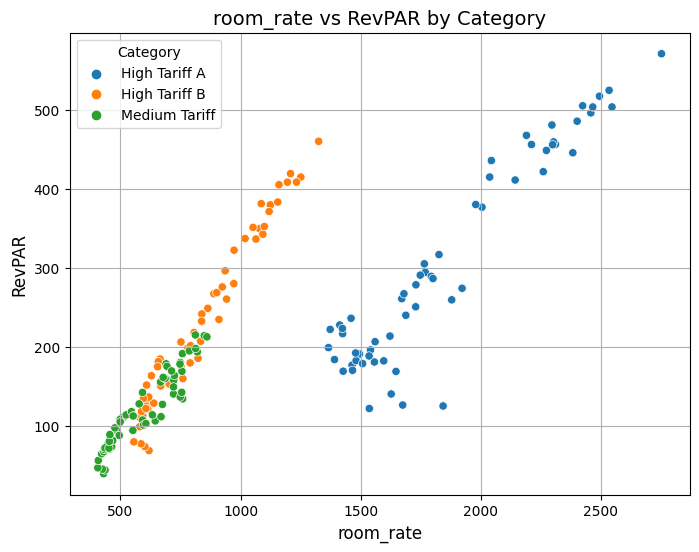

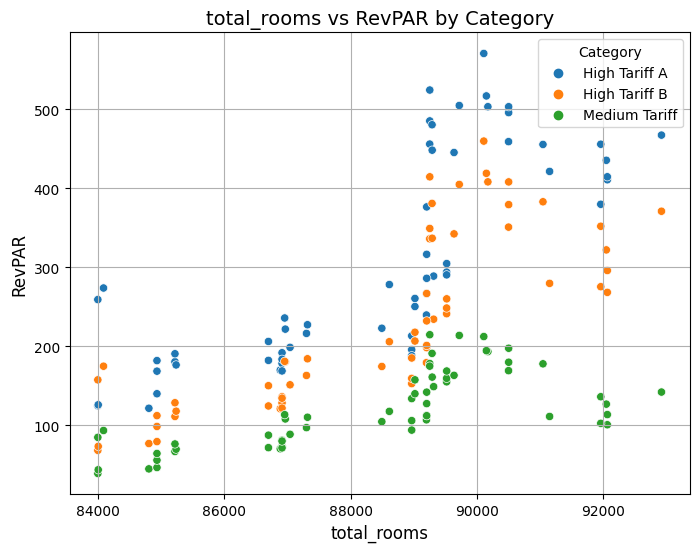

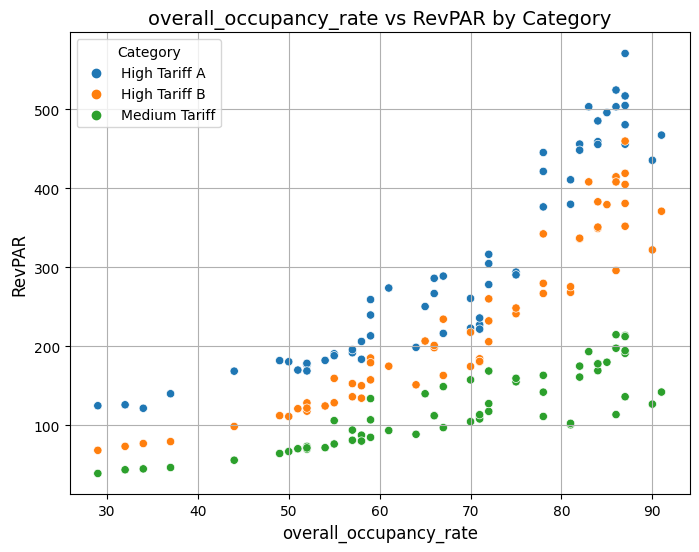

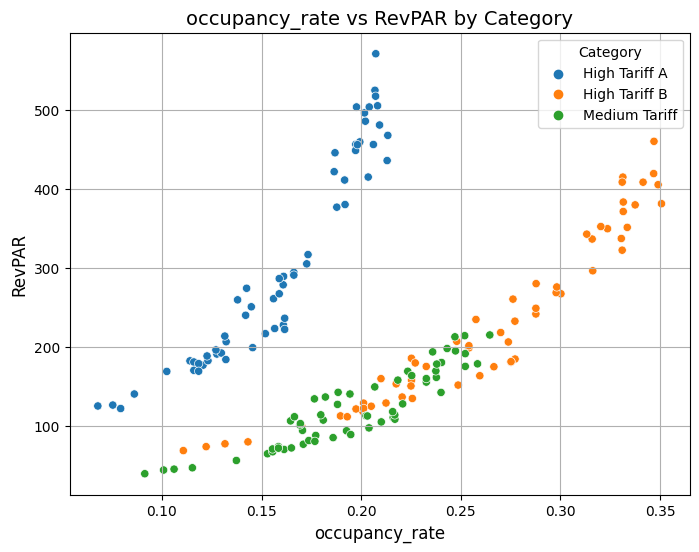

In [156]:
scatterplot_analysis(merged_df, scatternumerical_cols, target_col)

In [157]:
# Define numerical and categorical columns
numerical_cols = ['room_rate', 'rooms_available', 'total_rooms', 'overall_occupancy_rate', 'occupancy_rate', 'RevPAR']
scatternumerical_cols = ['room_rate', 'total_rooms', 'overall_occupancy_rate', 'occupancy_rate', 'RevPAR']
advancednumerical_cols = ['room_rate', 'rooms_available', 'occupancy_rate', 'RevPAR']
categorical_cols = ['category']
target_col = 'RevPAR'

def scatterplot_analysis(df, numerical_cols, target_col='RevPAR'):
    """
    Perform scatterplot analysis to visualize relationships between numerical columns and the target column.
    The plots are grouped by the 'category' column.
    """
    for col in numerical_cols:
        if col != target_col:  # Avoid plotting the target column against itself
            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=df, x=col, y=target_col, hue='category')
            plt.title(f'{col} vs {target_col} by Category', fontsize=14)
            plt.xlabel(col, fontsize=12)
            plt.ylabel(target_col, fontsize=12)
            plt.legend(title='Category', fontsize=10)
            plt.grid(True)
            plt.show()

In [158]:
# Step 1: Dataset Overview
def get_dataset_overview(df):
    # Suppress warnings
    import warnings
    warnings.filterwarnings('ignore', category=RuntimeWarning)

    print("Dataset Overview:")
    print(f"Shape: {df.shape}\n")
    
    print("Info:")
    print(df.info(memory_usage='deep'))
    print("\nSummary Statistics:\n")
    
    # Separate numeric and categorical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns
    
    # Display summary statistics for numeric columns
    if not numeric_cols.empty:
        print("Numeric Columns:\n")
        print(df[numeric_cols].describe())
    
    # Display summary statistics for categorical columns
    if not categorical_cols.empty:
        print("\nCategorical Columns:\n")
        print(df[categorical_cols].describe(include='all'))

get_dataset_overview(merged_df)

Dataset Overview:
Shape: (180, 8)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   year_month              180 non-null    datetime64[ns]
 1   category                180 non-null    object        
 2   room_rate               180 non-null    int64         
 3   rooms_available         180 non-null    float64       
 4   overall_occupancy_rate  180 non-null    int64         
 5   total_rooms             180 non-null    int64         
 6   occupancy_rate          180 non-null    float64       
 7   RevPAR                  180 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 22.3 KB
None

Summary Statistics:

Numeric Columns:

         room_rate  rooms_available  overall_occupancy_rate   total_rooms  \
count   180.000000       180.000000              180

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


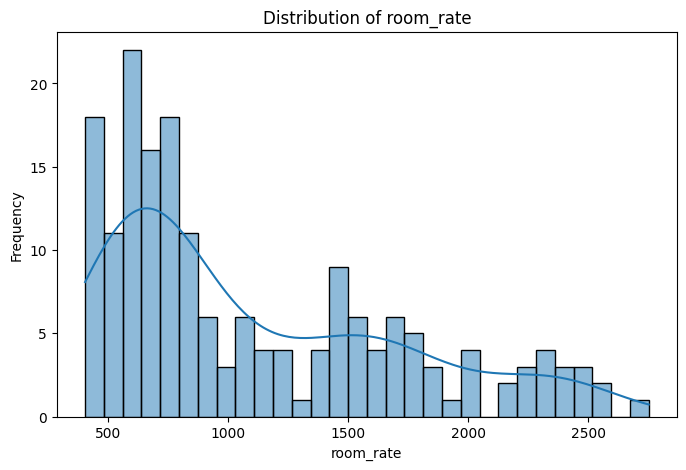

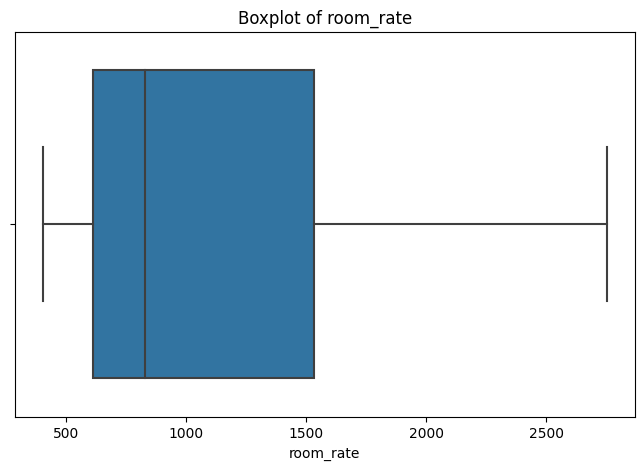

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


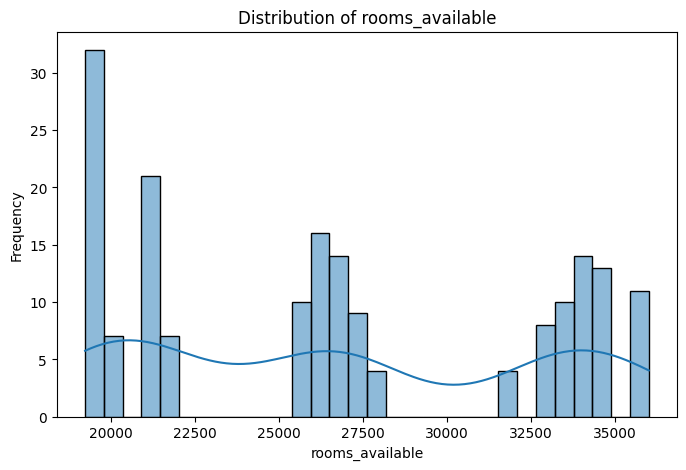

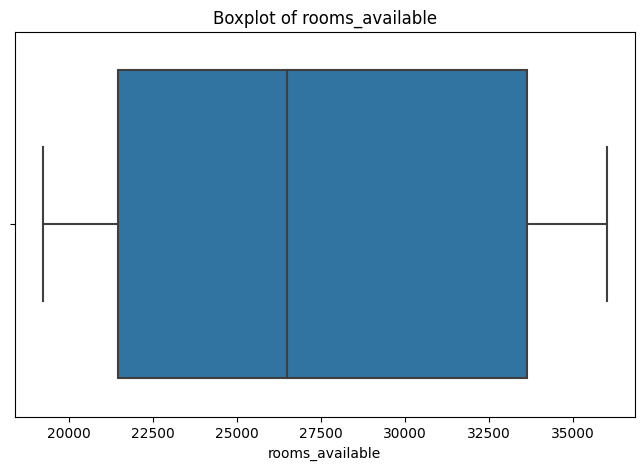

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


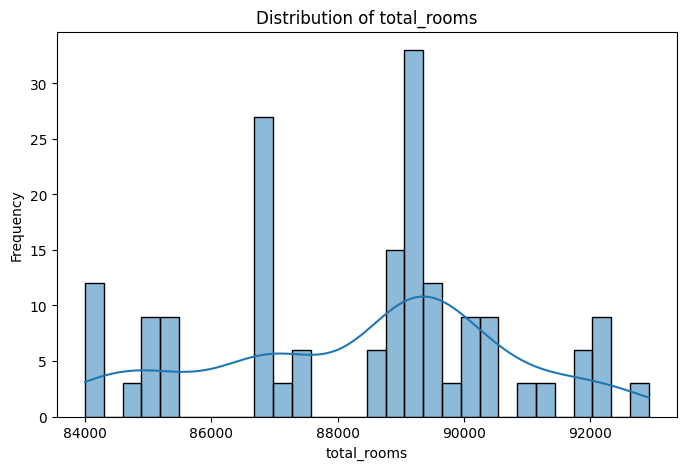

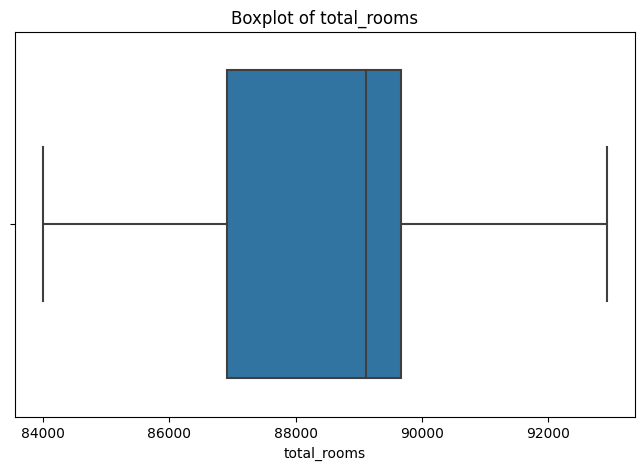

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


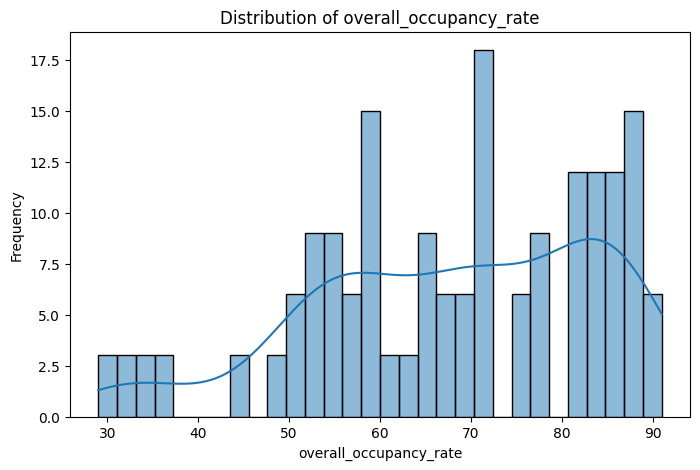

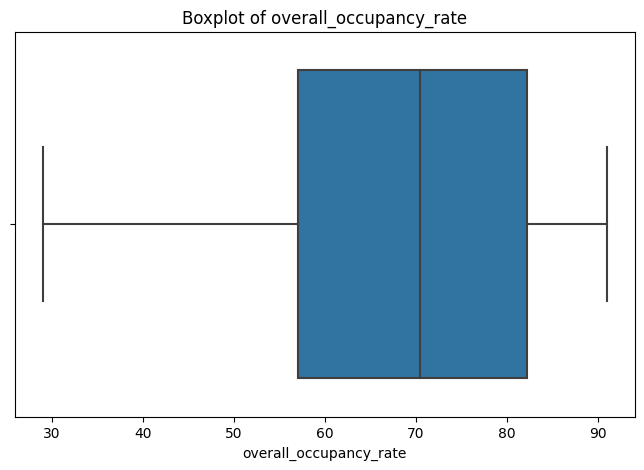

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


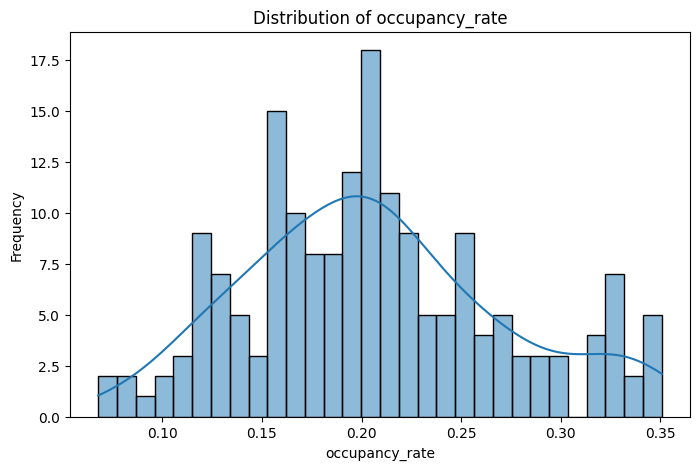

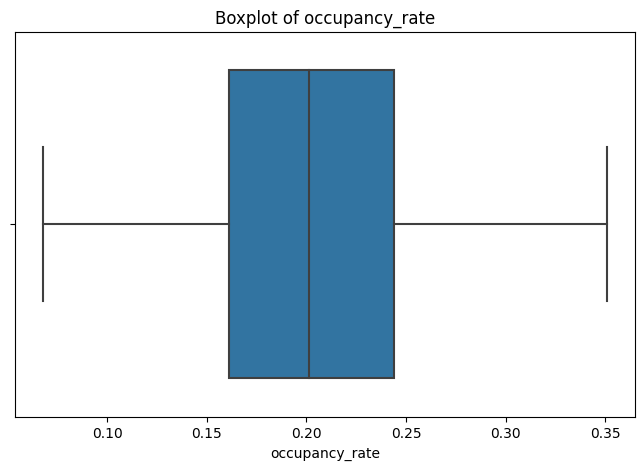

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


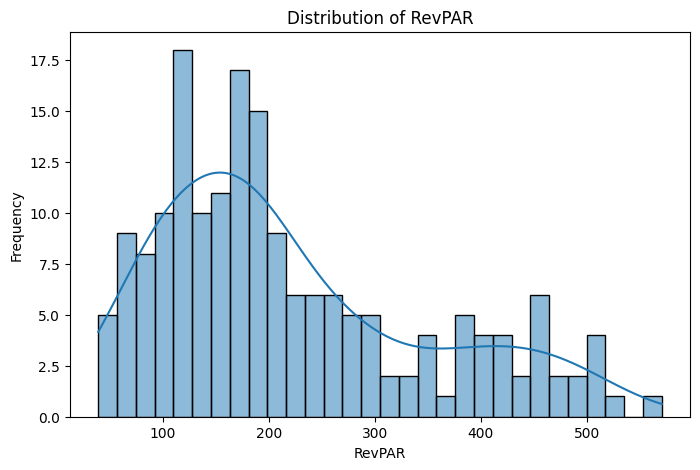

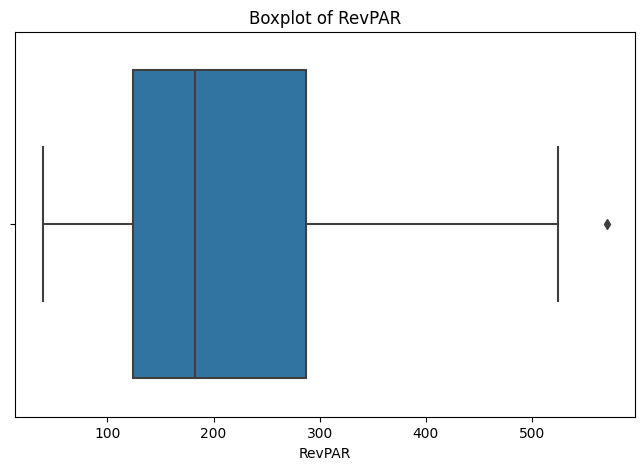

In [159]:
# Step 2: Univariate Analysis
def univariate_analysis(df, numerical_cols):
    # Convert inf and -inf to NaN
    df[numerical_cols] = df[numerical_cols].replace([np.inf, -np.inf], np.nan)

    # Ensure numerical columns are numeric
    df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce')
    
    for col in numerical_cols:
        # Histogram with KDE
        plt.figure(figsize=(8, 5))
        sns.histplot(df[col].dropna(), kde=True, bins=30)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
        
        # Boxplot
        plt.figure(figsize=(8, 5))
        sns.boxplot(x=df[col].dropna())
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)
        plt.show()

univariate_analysis(merged_df, numerical_cols)

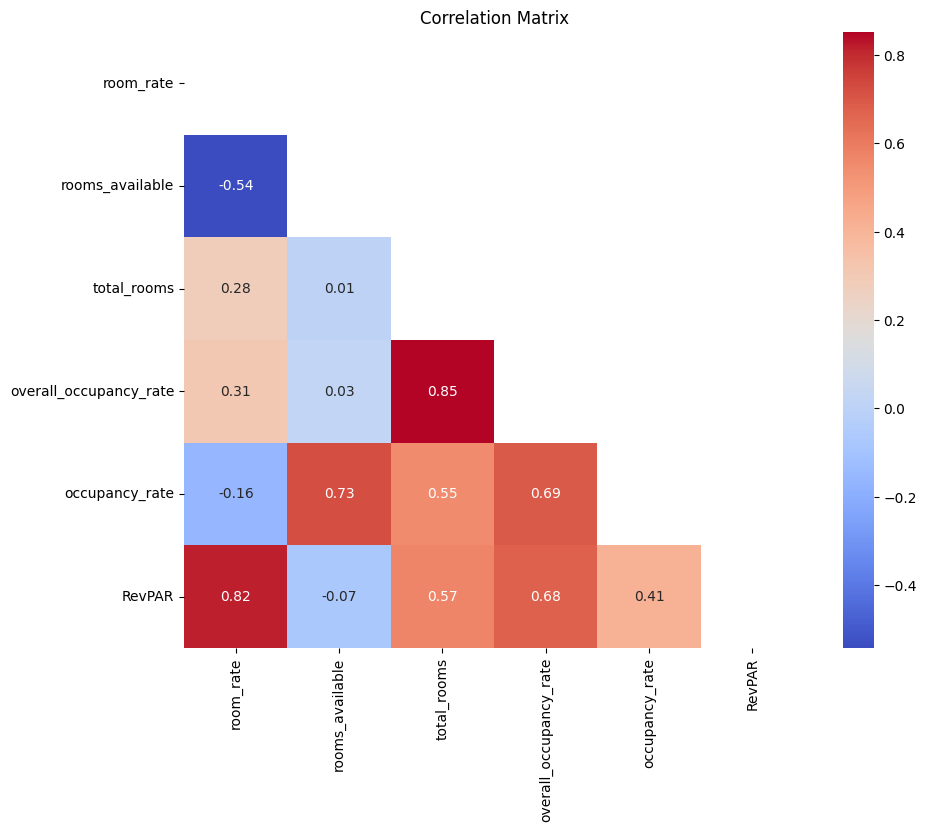

In [160]:
# Step 3: Bivariate Analysis
def bivariate_analysis(df, numerical_cols):
    correlation_matrix = df[numerical_cols].corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
    plt.title('Correlation Matrix')
    plt.show()

bivariate_analysis(merged_df, numerical_cols)

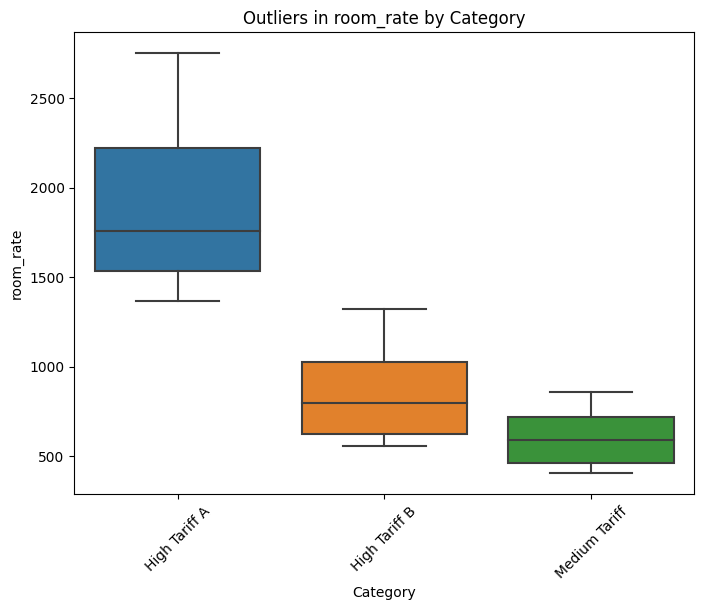

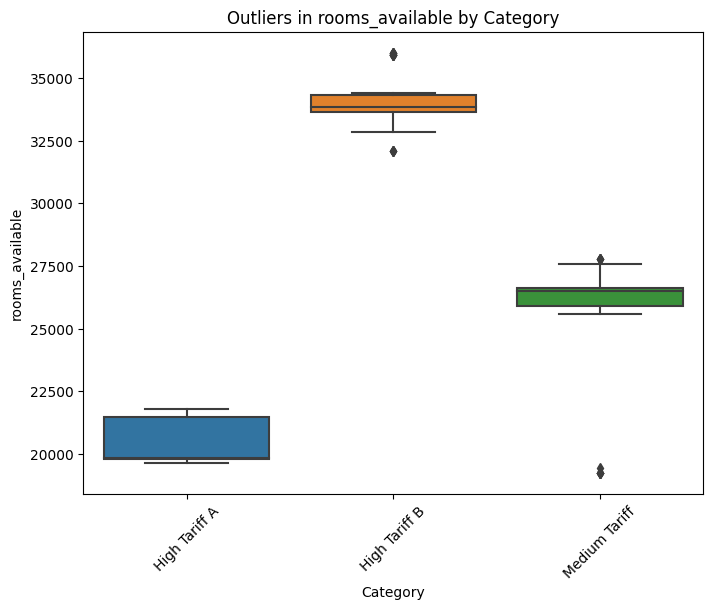

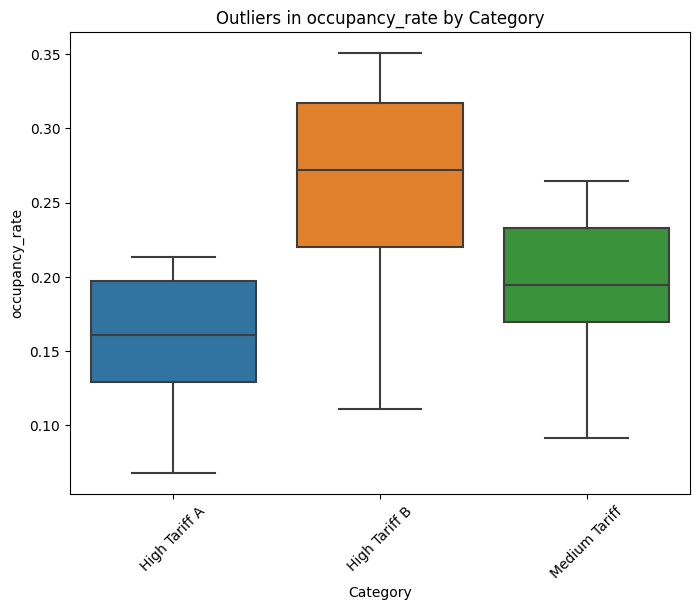

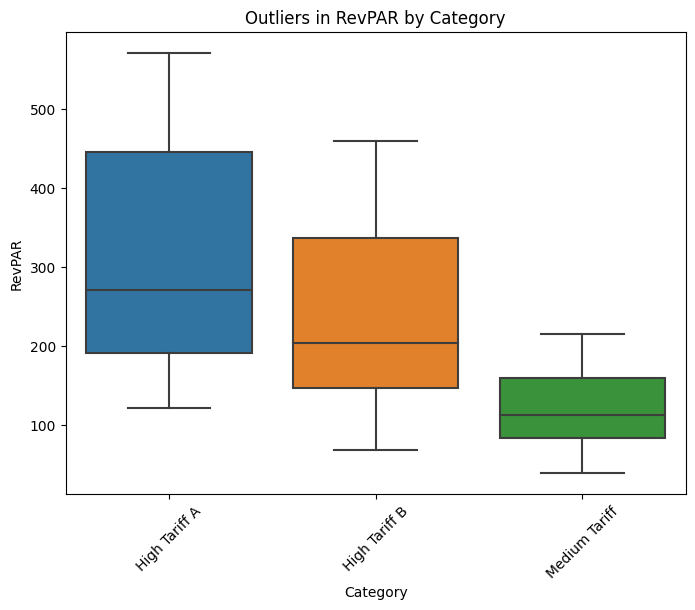

                            OLS Regression Results                            
Dep. Variable:                 RevPAR   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.879e+32
Date:                Tue, 04 Feb 2025   Prob (F-statistic):               0.00
Time:                        13:35:50   Log-Likelihood:                 5287.0
No. Observations:                 180   AIC:                        -1.056e+04
Df Residuals:                     175   BIC:                        -1.055e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -2.132e-13   4.09e-14     

In [161]:
# Step 4: Advanced Insights
def advanced_insights(df, numerical_cols, target_col='RevPAR'):
    # Outlier Detection: Boxplots
    for col in numerical_cols:
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=df, x='category', y=col)
        plt.title(f'Outliers in {col} by Category')
        plt.xlabel('Category')
        plt.ylabel(col)
        plt.xticks(rotation=45)
        plt.show()
    
    # Regression Analysis
    X = df[numerical_cols]
    y = df[target_col]
    X = add_constant(X)
    model = OLS(y, X).fit()
    print(model.summary())

advanced_insights(merged_df, advancednumerical_cols)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

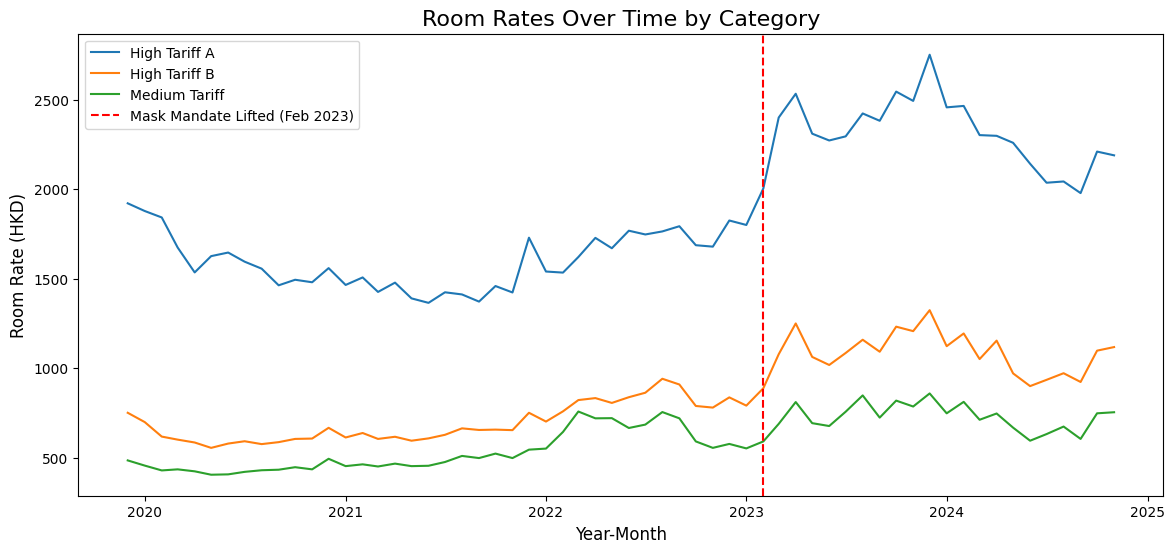

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

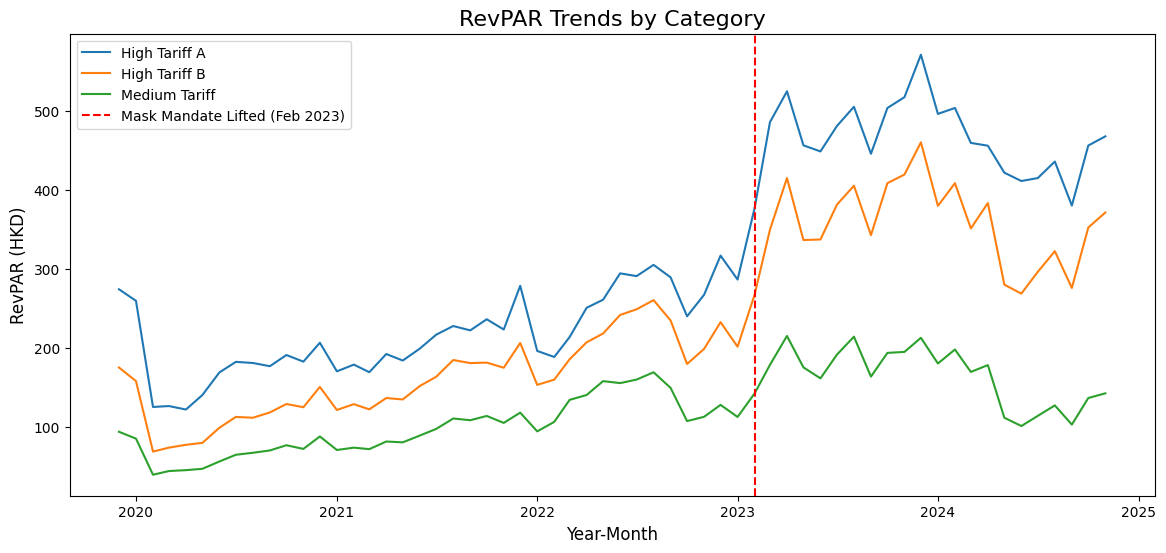

In [162]:
# Step 5: Exploratory Data Analysis (EDA)
def perform_eda(df):
    # Replace infinite values with NaN
    df = df.replace([np.inf, -np.inf], np.nan)
    mark_date = pd.to_datetime('2023-02')  # Mask mandate lift date
    
    # Plot Room Rates Over Time by Category
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=df, x='year_month', y='room_rate', hue='category')
    plt.title('Room Rates Over Time by Category', fontsize=16)
    plt.xlabel('Year-Month', fontsize=12)
    plt.ylabel('Room Rate (HKD)', fontsize=12)
    plt.axvline(x=mark_date, color='red', linestyle='--', label='Mask Mandate Lifted (Feb 2023)')
    plt.legend()
    plt.show()
    
    # Plot RevPAR Trends by Category
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=df, x='year_month', y='RevPAR', hue='category')
    plt.title('RevPAR Trends by Category', fontsize=16)
    plt.xlabel('Year-Month', fontsize=12)
    plt.ylabel('RevPAR (HKD)', fontsize=12)
    plt.axvline(x=mark_date, color='red', linestyle='--', label='Mask Mandate Lifted (Feb 2023)')
    plt.legend()
    plt.show()

perform_eda(merged_df)

In [163]:
# Step 6: Price Elasticity Calculation
def calculate_price_elasticity(df):
    # Ensure no division by zero
    df = df[(df['room_rate'] > 0) & (df['occupancy_rate'] > 0)]
    df['price_elasticity'] = (
        df.groupby('category')['occupancy_rate'].pct_change() /
        df.groupby('category')['room_rate'].pct_change()
    )
    df['price_elasticity'] = df['price_elasticity'].replace([np.inf, -np.inf], np.nan)
    elasticity_summary = df.groupby('category')['price_elasticity'].mean().reset_index()
    print("Price Elasticity Summary:")
    print(elasticity_summary)
    return elasticity_summary

calculate_price_elasticity(merged_df)

Price Elasticity Summary:
        category  price_elasticity
0  High Tariff A          1.243965
1  High Tariff B          0.599757
2  Medium Tariff          3.107659


,category,price_elasticity
0,High Tariff A,1.243965
1,High Tariff B,0.599757
2,Medium Tariff,3.107659


Columns in DataFrame: ['year_month', 'category', 'room_rate', 'rooms_available', 'overall_occupancy_rate', 'total_rooms', 'occupancy_rate', 'RevPAR']
Random Forest: Number of Estimators: 100
Gradient Boosting: Number of Estimators: 100

Optimized Model Performance Metrics:
-------------------------------------------------------------------------------------
               Model    Test R²   Test MSE   Test MAE   CV R² Mean  CV R² Std
-------------------------------------------------------------------------------------
Linear Regression         0.979    292.260     12.414        0.975      0.006
Decision Tree             0.973    373.910     13.469        0.981      0.007
Random Forest             0.995     70.291      5.949        0.989      0.006
Gradient Boosting         0.987    185.530      9.196        0.991      0.004
KNN                       0.975    345.942     14.126        0.964      0.018
SVM                       0.914   1203.311     21.968        0.782      0.041


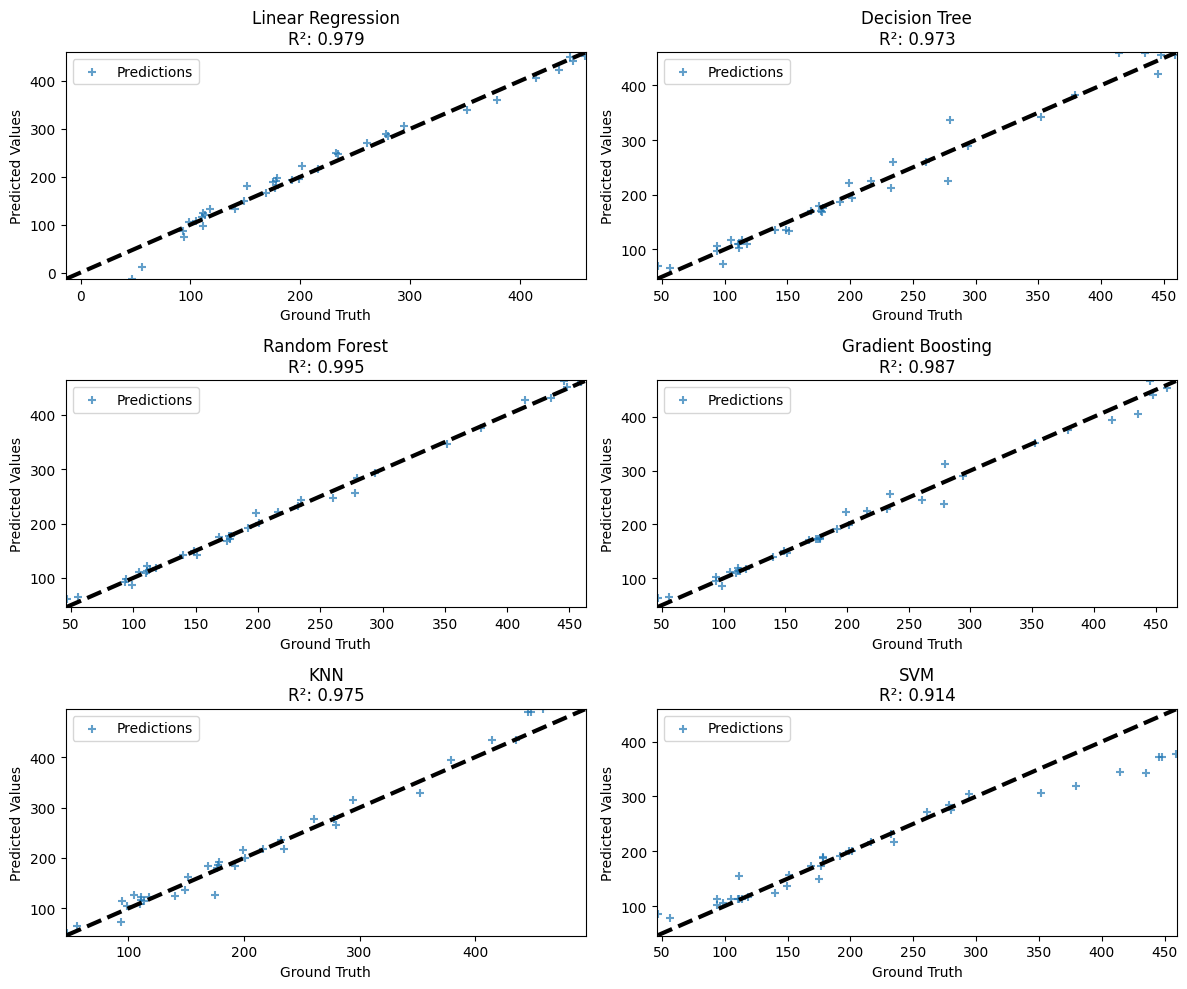

In [168]:
def optimize_regression_models(df):
    # Check if DataFrame is empty
    if df.empty:
        raise ValueError("The provided DataFrame is empty.")
    
    # Print column names for debugging
    print("Columns in DataFrame:", df.columns.tolist())
    
    # Data Preparation
    required_columns = ['room_rate', 'overall_occupancy_rate', 'rooms_available', 'total_rooms', 'occupancy_rate']
    
    # Check for missing columns
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise KeyError(f"The following required columns are missing from the DataFrame: {missing_columns}")
    
    # Check if target variable 'RevPAR' exists
    if 'RevPAR' not in df.columns:
        raise KeyError("The target variable 'RevPAR' is missing from the DataFrame.")
    
    X = df[required_columns]
    y = df['RevPAR']
    
    # Split the data first to avoid leakage
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Handle missing values within each split
    X_train = X_train.dropna()
    y_train = y_train.loc[X_train.index]
    X_test = X_test.dropna()
    y_test = y_test.loc[X_test.index]
    
    # Feature Scaling using training data only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize models with optimized parameters
    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': GridSearchCV(DecisionTreeRegressor(random_state=42),
                                   {'max_depth': [3, 5, 7],
                                    'min_samples_split': [2, 5, 10],
                                    'min_samples_leaf': [1, 2, 4]}),
        'Random Forest': GridSearchCV(RandomForestRegressor(random_state=42),
                                   {'n_estimators': [50, 100],
                                    'max_depth': [5, 10],
                                    'min_samples_split': [2, 5]}),
        'Gradient Boosting': GridSearchCV(GradientBoostingRegressor(random_state=42),
                                        {'n_estimators': [50, 100],
                                         'learning_rate': [0.05, 0.1],
                                         'max_depth': [3, 5]}),
        'KNN': GridSearchCV(KNeighborsRegressor(),
                          {'n_neighbors': [5, 7, 9]}),
        'SVM': GridSearchCV(SVR(kernel='rbf'),
                          {'C': [1, 10], 
                           'gamma': ['scale']})
    }
    
    # Train models and collect metrics and predictions for plotting
    results = []
    predictions = {}
    
    for name, model in models.items():
        try:
            model.fit(X_train_scaled, y_train)
            best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model
            
            cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='r2')
            y_pred = best_model.predict(X_test_scaled)
            
            metrics = {
                'R2': r2_score(y_test, y_pred),
                'MSE': mean_squared_error(y_test, y_pred),
                'MAE': mean_absolute_error(y_test, y_pred),
                'CV R2 Mean': cv_scores.mean(),
                'CV R2 Std': cv_scores.std()
            }
            
            results.append((name, metrics))
            predictions[name] = (y_test.values, y_pred)  # Store actual and predicted values
            
            # Print number of estimators for relevant models
            if hasattr(best_model, "n_estimators"):
                print(f"{name}: Number of Estimators: {best_model.n_estimators}")
        
        except Exception as e:
            print(f"Error processing {name}: {e}")
    
    # Print formatted results
    print("\nOptimized Model Performance Metrics:")
    print("-" * 85)
    print(f"{'Model':>20} {'Test R²':>10} {'Test MSE':>10} {'Test MAE':>10} {'CV R² Mean':>12} {'CV R² Std':>10}")
    print("-" * 85)

    for entry in results:
        if not isinstance(entry, tuple) or len(entry) != 2:
            print(f"Invalid entry found: {entry}")
    
    for name, metrics in results:
        print(f"{name:<20} "
              f"{metrics['R2']:>10.3f} "
              f"{metrics['MSE']:>10.3f} "
              f"{metrics['MAE']:>10.3f} "
              f"{metrics['CV R2 Mean']:>12.3f} "
              f"{metrics['CV R2 Std']:>10.3f}")
    
    # Plotting predictions vs actual values for each model
    plt.figure(figsize=(12, 10))
    
    for idx, (name, (y_true, y_pred)) in enumerate(predictions.items()):
        plt.subplot(3, 2, idx + 1)
        
        # Scatter plot of actual vs predicted values
        plt.scatter(y_true, y_pred, marker='+', label='Predictions', alpha=0.7)
        
        # Reference line where predicted equals actual (ideal fit)
        xmin = min(y_true.min(), y_pred.min())
        xmax = max(y_true.max(), y_pred.max())
        plt.plot([xmin,xmax], [xmin,xmax], lw=3, color='k', ls='--') 
        
        plt.xlabel('Ground Truth')
        plt.ylabel('Predicted Values') 
        plt.title(f'{name}\nR²: {r2_score(y_true, y_pred):.3f}')
        plt.legend()
        
        plt.xlim([xmin - 1, xmax + 1])  # Add some padding to x-axis limits
        plt.ylim([xmin - 1, xmax + 1])  # Add some padding to y-axis limits
    
    plt.tight_layout()  # Adjust subplots to fit into figure area.
    
    # Save the figure if needed (uncomment the following line)
    # plt.savefig('predictions_comparison.png')
    
    plt.show()  # Display the plots

# Example usage:
# Assuming merged_df is a pandas DataFrame containing the necessary columns
# merged_df = pd.read_csv('your_data.csv')
optimize_regression_models(merged_df)


Conclusion
In this analysis, we evaluated several regression models to predict the RevPAR (Revenue per Available Room) using a limited dataset. Despite the small size of our data, the models demonstrated impressive performance metrics, indicating their ability to generalize well.

Key Findings:
The Random Forest model achieved the highest Test R² score of 0.995, along with a Test MSE of 70.291 and a Test MAE of 5.949. This suggests that the model is highly effective in predicting RevPAR with minimal error.
The Gradient Boosting model also performed exceptionally well, with a Test R² of 0.987, making it a strong alternative to Random Forest.
Linear Regression and Decision Tree models also yielded high Test R² scores of 0.979 and 0.973, respectively, indicating good predictive capabilities.
Conversely, the Support Vector Machine (SVM) model had the lowest performance, with a Test R² of 0.914 and a higher Test MSE of 1203.311, suggesting that it may not be the best fit for this dataset.
Implications
The results demonstrate that even with a small dataset, our models can effectively predict RevPAR. The high R² values across all models, especially for Random Forest and Gradient Boosting, indicate that the features included in the dataset are relevant and informative for the task at hand.

Future work could involve gathering additional data to further validate and potentially enhance the model performance. Overall, these findings highlight the potential for effective revenue management strategies in the hospitality industry using predictive modeling techniques.

